# Exploration 9
## 폐렴 진단기 성능개선
---

## 목차
- Step 1. 실험환경 Set-up
- Step 2. 데이터 준비하기
- Step 3. 데이터 시각화
- Step 4. CNN 모델링
- Step 5. 데이터 imbalance 처리
- Step 6. 모델 훈련
- Step 7. 결과 확인과 시각화
- Step 8. 다른 방법 도입해 보기
---

# Step 0. Imports

In [1]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
from tensorflow.keras.callbacks import EarlyStopping
warnings.filterwarnings(action='ignore')

# Step 1. 실험환경 Set-up
- 이미지 사이즈 설정
- 데이터 경로 설정
- batch size 설정
- epoch 설정

In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 32
EPOCHS = 25

print(ROOT_PATH)

/aiffel/aiffel


# Step 2. 데이터 준비하기

### 데이터 가져오기

In [3]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


#### validation set의 개수가 적으므로 train, validation set을 합치고 다시 분할

In [4]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


### 데이터 불균형 확인 
- 파일 경로에 'NOMAL'이 있으면 정상 없으면 비정상

In [5]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")
COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1072
Pneumonia images count in training set: 3113


### 인스턴스 만들기 (tf.data)

In [6]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

### train, test 개수 확인

In [7]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


### 파일 경로로 라벨 데이터 만들기

In [8]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

### 이미지 사이즈 조절

In [9]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

### train, validation set 만들기

In [10]:
# num_parallel_calls파라미터에 위에서 할당한 AUTOTUNE변수를 이용하면 더욱 빠르게 데이터를 처리함
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

### 이미지 사이즈, 라벨 확인

In [11]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


### test set 만들기

In [12]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


### 데이터셋 만들기 (augemtation 미사용)
- shiffle(): 고정크기 버퍼를 유지하고 해당 버퍼에서 무작위로 균일하게 다음요소를 선택
- repeat(): epoch를 진행하면서 여러 번 데이터셋을 불러오게 되는데, 이때 repeat()를 사용한 데이터 셋의 경우 여러 번 데이터셋을 사용할 수 있게 해준다.
- batch(): 자신이 정한 배치사이즈만큼 배치로 주어진다.
- prefetch(): 첫 번째 데이터를 GPU에서 학습하는 동안 두 번째 데이터를 CPU에서 준비할 수 있어 리소스의 유휴 상태를 줄일 수 있다.

In [13]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

# Step 3. 데이터 시각화

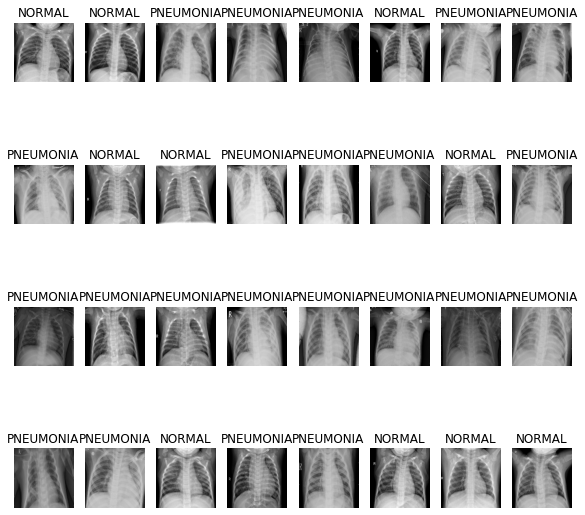

In [14]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

# Step 4. CNN 모델링
- Conv: Batch Normalization(variance shift를 억제)
- Dense: Dropout(variance shift를 유발)

In [15]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [16]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [17]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

# Step 5. 데이터 imbalance 처리
Weight balanceing
- training set의 각 데이터에서 loss를 계산할 때 특정 클래스의 데이터에 더 큰 loss 값을 갖도록 가중치를 부여하는 방법

In [18]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


# Step 6. 모델 훈련 
- device: GPU
- loss: binary_cross entropy
- optimizer: adam
- metrics: accurancy, precision, recall

In [19]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [20]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
130/130 [==============================] - 60s 366ms/step - loss: 0.3713 - accuracy: 0.8101 - precision: 0.9594 - recall: 0.7778 - val_loss: 0.6228 - val_accuracy: 0.7354 - val_precision: 0.7354 - val_recall: 1.0000
Epoch 2/25
130/130 [==============================] - 47s 366ms/step - loss: 0.2184 - accuracy: 0.9187 - precision: 0.9738 - recall: 0.9152 - val_loss: 0.8614 - val_accuracy: 0.7354 - val_precision: 0.7354 - val_recall: 1.0000
Epoch 3/25
130/130 [==============================] - 47s 367ms/step - loss: 0.1751 - accuracy: 0.9334 - precision: 0.9757 - recall: 0.9338 - val_loss: 1.0344 - val_accuracy: 0.7373 - val_precision: 0.7373 - val_recall: 1.0000
Epoch 4/25
130/130 [==============================] - 49s 379ms/step - loss: 0.1357 - accuracy: 0.9517 - precision: 0.9850 - recall: 0.9498 - val_loss: 1.5631 - val_accuracy: 0.7373 - val_precision: 0.7373 - val_recall: 1.0000
Epoch 5/25
130/130 [==============================] - 52s 398ms/step - loss: 0.1474 - accura

# Step 7. 결과 확인과 시각화
- 결과 시각화
- 모델 평가

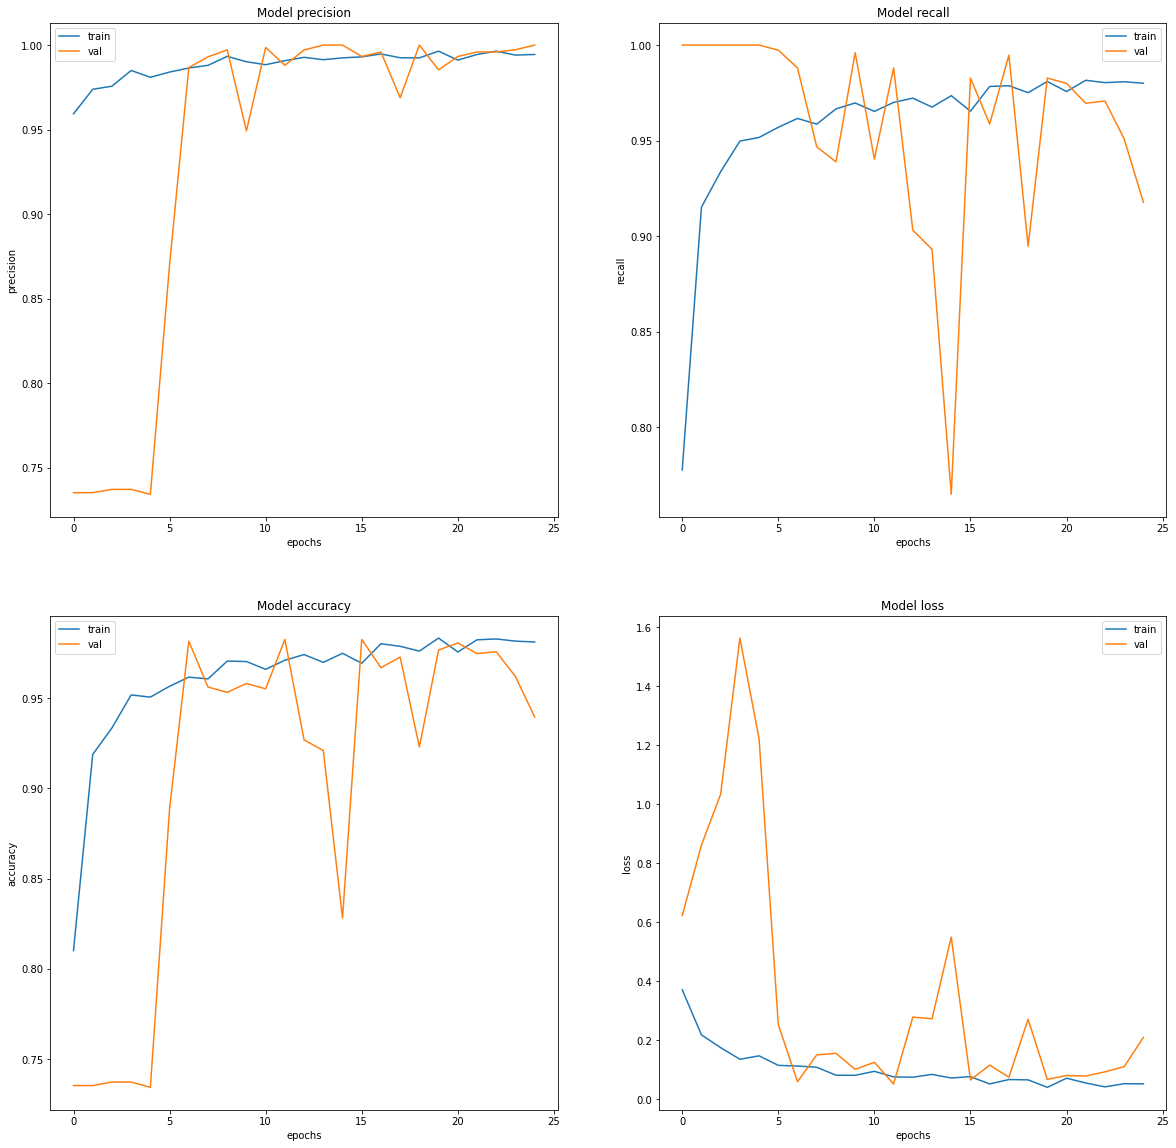

In [21]:
fig, ax = plt.subplots(2, 2, figsize=(20, 20))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [22]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

20/20 [==============================] - 4s 210ms/step - loss: 0.5276 - accuracy: 0.8670 - precision: 0.8545 - recall: 0.9487
Loss: 0.5275536179542542,
Accuracy: 0.8669871687889099,
Precision: 0.8545034527778625,
Recall: 0.9487179517745972


# Step 8. 다른 방법시도해 보기
- batch size 16 -> 32로 변경
- 다른 augmentation 사용: tensorflow keras의 전처리 레이어

### train, val, test set 

In [23]:
# num_parallel_calls파라미터에 위에서 할당한 AUTOTUNE변수를 이용하면 더욱 빠르게 데이터를 처리함
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


### 데이터 셋 만들기
- augmentation 부분을 삭제 (모델에 추가 할 예정)

In [24]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

### CNN 모델링 
- Conv: Batch Normalization(variance shift를 억제)
- Dense: Dropout(variance shift를 유발)
- Augmentation: 이미지 회전과 같은 무작위 변환을 적용하여 훈련 데이터의 다양성을 증가

In [25]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [26]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

augmentation 
- RandomFlip: 훈련 중에 이미지를 무작위로 뒤집음
- RandomRotation: 훈련 중에 이미지를 무작위로 돌림
- RandomZoom: 훈련 중에 이미지를 무작위로 확대,축소함
- RandomTranslation: 훈련 중에 이미지를 무작위로 translation함

In [27]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    tf.keras.layers.experimental.preprocessing.RandomZoom(-0.2,0.2),
    tf.keras.layers.experimental.preprocessing.RandomTranslation(height_factor=0.1,
                                                                 width_factor=0.1,
                                                                 fill_mode='constant')
])

In [28]:
def build_model():
    model_new = tf.keras.Sequential([
        data_augmentation,
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

### 데이터 imbalance 처리
Weight balanceing
- training set의 각 데이터에서 loss를 계산할 때 특정 클래스의 데이터에 더 큰 loss 값을 갖도록 가중치를 부여하는 방법

In [29]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


### 모델 훈련
- device: GPU
- loss: binary_cross entropy
- optimizer: adam
- metrics: accurancy, precision, recall

In [30]:
with tf.device('/GPU:0'):
    model_new = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [31]:
with tf.device('/GPU:0'):
    history = model_new.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
130/130 [==============================] - 56s 366ms/step - loss: 0.0476 - accuracy: 0.9827 - precision: 0.9951 - recall: 0.9816 - val_loss: 0.1009 - val_accuracy: 0.9736 - val_precision: 0.9945 - val_recall: 0.9694
Epoch 2/25
130/130 [==============================] - 47s 364ms/step - loss: 0.0522 - accuracy: 0.9839 - precision: 0.9944 - recall: 0.9838 - val_loss: 0.0862 - val_accuracy: 0.9736 - val_precision: 0.9973 - val_recall: 0.9667
Epoch 3/25
130/130 [==============================] - 47s 366ms/step - loss: 0.0381 - accuracy: 0.9858 - precision: 0.9954 - recall: 0.9854 - val_loss: 0.0576 - val_accuracy: 0.9756 - val_precision: 0.9777 - val_recall: 0.9894
Epoch 4/25
130/130 [==============================] - 48s 370ms/step - loss: 0.0456 - accuracy: 0.9837 - precision: 0.9957 - recall: 0.9823 - val_loss: 0.1672 - val_accuracy: 0.9609 - val_precision: 0.9986 - val_recall: 0.9483
Epoch 5/25
130/130 [==============================] - 49s 382ms/step - loss: 0.0346 - accura

### 결과 확인 및 모델 평가

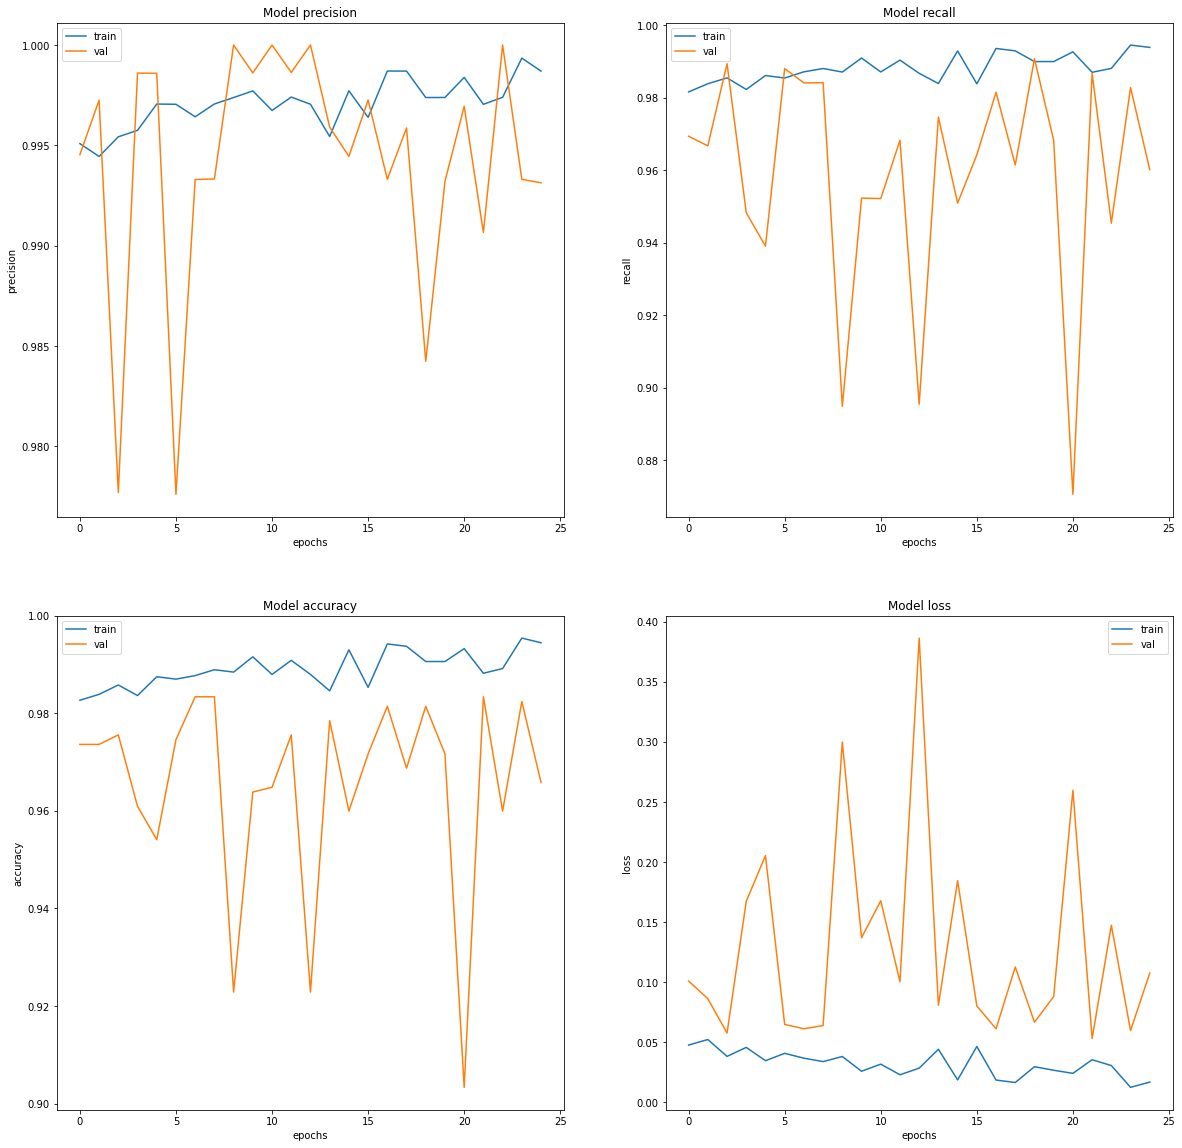

In [32]:
fig, ax = plt.subplots(2, 2, figsize=(20, 20))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [33]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

20/20 [==============================] - 4s 200ms/step - loss: 0.9386 - accuracy: 0.8189 - precision: 0.7809 - recall: 0.9872
Loss: 0.9386005997657776,
Accuracy: 0.8189102411270142,
Precision: 0.7809330821037292,
Recall: 0.9871794581413269


# 프로젝트 정리 

## 결과 분석 
#### Train 
- device: GPU
- loss: binary_cross entropy
- optimizer: adam
- metrics: accurancy, precision, recall

#### CNN
- Conv: Batch Normalization(variance shift를 억제)
- Dense: Dropout(variance shift를 유발)
- Augmentation: 이미지 회전과 같은 무작위 변환을 적용하여 훈련 데이터의 다양성을 증가

#### Augmentation 
- RandomFlip: 훈련 중에 이미지를 무작위로 뒤집음
- RandomRotation: 훈련 중에 이미지를 무작위로 돌림
- RandomZoom: 훈련 중에 이미지를 무작위로 확대,축소함
- RandomTranslation: 훈련 중에 이미지를 무작위로 translation함

#### 첫 번째 모델 (augmentation 사용 X)
metrics|n
---|---
Loss|0.5275536179542542,
Accuracy|0.8669871687889099,
Precision|0.8545034527778625,
Recall|0.9487179517745972  

#### 두 번째 모델 (여러가지 augmentation 사용 O)
metrics|n
---|---
Loss|0.9386005997657776,
Accuracy|0.8189102411270142,
Precision|0.7809330821037292,
Recall|0.9871794581413269

#### 정리
- 처음 모델에서 accuracy가 __0.8669871687889099__가 나왔습니다. 하지만 augmentation기법을 적용한 두 번째 모델에서는 accuracy가 더 떨어진 __0.8189102411270142__가 나왔습니다. 
- 하지만 페렴진단의 겨우 metrics로 recall을 사용하는 것이 적합하다고 생각하는데 첫 번째 모델보다 두 번째 모델이 더 recall측면에서 더 좋았습니다.
- augmentation을 사용했는데 정확도가 더 떨어진 이유는 아무래도 데이터의 양이 적다는 문제와 폐렴 진단이라는 특성 때문에 그런것 같습니다.
- 사실 모델을 50번 넘게 돌려봤는데 그 때마다 accuracy가 10%이상이 차이가 났습니다. 이는 앞서 말한것과 같이 학습 데이터의 양이 부족하기 때문인것 같았습니다.

## 느낀 점 
- 폐렴 진단과 같은 분류에서는 정확한 확직자 예측을 위해 metric을 accurancy보다는 recall로 잡아야한다고 생각했습니다. 그런데 모델의 성능을 계속해서 분석하던도 중 아무리 recall이 중요하더라도 어느 정도의 accurancy가 뒷 받침해주고 그 다음이 recall이라는 생각이 들었습니다. 
- augmentation이라는 기법을 처음 접하고 처음 사용하여 보았는데 사용조건이 너무 까다로운 같았습니다. 그 이유는 노드에서 나와있듯이 폐렴 이미지는 종양의 위치, 각도, 모양.. 등등이 매우 주요한 사항인데 augmentation으로 이것들을 무작위로 변경하여 새로운 이미지를 가지고 훈련을 하면 의미가 없는것 같았습니다. 또한 여기서는 augmentation기법을 affine trainsform만을 이용하여서 더욱 그러한 느낌이듭니다.

## 개선 방안 
- 아무래도 폐렴과 같은 질병은 눈으로 쉽게 관찰할 수가 없습니다. 따라서 X-RAY사진만으로는 질병을 예측하기에는 부족하고 시기, 나이, 건강도.. 등등 다른 수치적인 데이터와 함께 사용한다면 더욱 예측이 쉽게 될 수 있을것 같습니다.
- 이번에 데이터 양이 너무 부족하다는 생각이 들었습니다. 데이터양을 늘리면 더욱 쉽게 예측할 수 있을것 같습니다.